# 1. Aquisição e transformação dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.metrics import geometric_mean_score

In [2]:
r_wine = pd.read_csv('datasets/winequality-red.csv', sep = ';')

In [3]:
x = r_wine.iloc[:, 0:-1]
y = r_wine.iloc[:, -1]

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
x_train = np.array(x_train)
x_test = np.array(x_test)

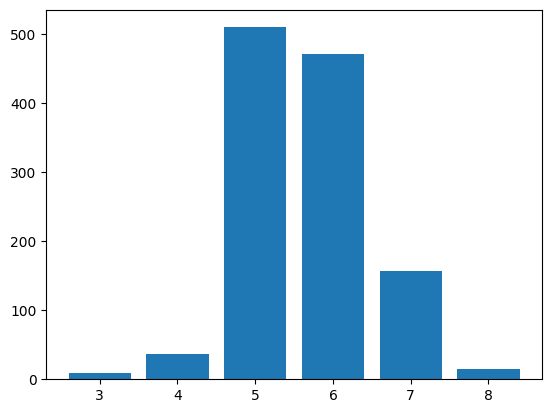

In [5]:
counter = Counter(y_train)
plt.bar(counter.keys(), counter.values())
plt.savefig('originaçl_data_r.png')
plt.show()

# 2. ADASYN e Undersampling

In [6]:
y_train.value_counts()

5    510
6    471
7    157
4     37
8     15
3      9
Name: quality, dtype: int64

In [7]:
wg = y_train.value_counts()

In [8]:
for i in range(0, len(wg)):
    if wg[i+3] < 6:
        wg[i+3] = 6

strategy1_w = {3:wg[3], 4:wg[4], 5:wg[5], 6:wg[6], 7:wg[7], 8:wg[8]}
fix = RandomOverSampler(sampling_strategy=strategy1_w)

In [9]:
wg[8] = round(0.15*wg[5])
wg[4] = round(0.2*wg[5])
wg[3] = round(0.1*wg[5])

strategy2_w = {3:wg[3], 4:wg[4], 8:wg[8]}
over = ADASYN(sampling_strategy=strategy2_w)

In [10]:
wg[5] = round(0.5*wg[5])
wg[6] = round(0.6*wg[6])

strategy3_w = {5:wg[5], 6:wg[6]}
under = RandomUnderSampler(sampling_strategy=strategy3_w)

In [11]:
steps = [('f', fix), ('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
x_train, y_train = pipeline.fit_resample(x_train, y_train)

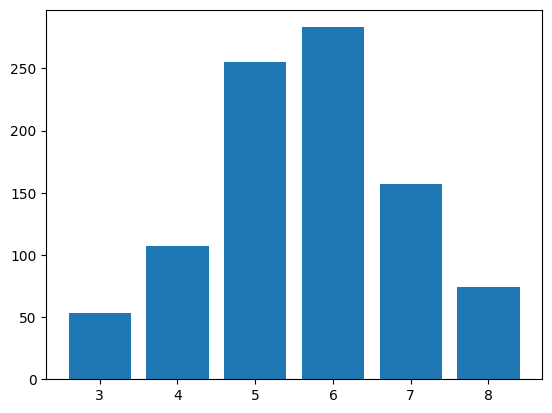

In [12]:
counter = Counter(y_train)
plt.bar(counter.keys(), counter.values())
plt.savefig('SMOTE_data_r.png')
plt.show()

# 3. Implementação da RNA

## 3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [13]:
# Import packages
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, KFold
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, recall_score, f1_score
from bayes_opt import BayesianOptimization
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
from scikeras.wrappers import KerasClassifier
from sklearn import metrics
import math

pd.set_option("display.max_columns", None)

2022-11-27 21:05:23.067581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 21:05:23.408468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-27 21:05:23.408485: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-27 21:05:23.445874: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-27 21:05:24.352305: W tensorflow/stream_executor/platform/de

In [14]:
score_acc = make_scorer(roc_auc_score)

In [15]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = scale(x_train)
x_test = scale(x_test)

In [16]:
y_train.shape

(929,)

In [17]:
def svm(c, gamma, w3, w4, w5, w6, w7, w8):

    weights = [w3, w4, w5, w6, w7, w8]

    w = {}
    for i in range(0, len(weights)):
        index = i+3
        w[index] = weights[i]

    svm_w = SVC(random_state=0, C=c, gamma=gamma, class_weight= w, probability=True)

    return svm_w

In [18]:
def evaluate_model(c, gamma, w3, w4, w5, w6, w7, w8):

    c = round(c, 3)
    gamma = round(gamma, 3)
    w3 = round(w3, 3)
    w4 = round(w4, 3)
    w5 = round(w5, 3)
    w6 = round(w6, 3)
    w7 = round(w7, 3)
    w8 = round(w8, 3)
    
    svm_w = svm(c, gamma, w3, w4, w5, w6, w7, w8)

    kf = KFold(n_splits=10, random_state=0, shuffle=True)
    score = []
    
    for train_index, test_index in kf.split(x_train):
        # print("TRAIN:", train_index, "TEST:", test_index)
        xtr, xte = x_train[train_index], x_train[test_index]
        ytr, yte = y_train[train_index], y_train[test_index]

        svm_w.fit(xtr, ytr)
        y_pred = svm_w.predict(xte)
        proba = svm_w.predict_proba(xte)

        roc = roc_auc_score(yte, proba, multi_class='ovr')
        acc = accuracy_score(yte, y_pred)
        score.append(math.sqrt(acc*roc))

    score = sum(score)/len(score)
    return score

In [82]:
pbounds = {'c': (0.001,100),
            'gamma': (0.001,100),
            'w3': (0.001,100),
            'w4': (0.001,100),
            'w5': (0.001,100),
            'w6': (0.001,100),
            'w7': (0.001,100),
            'w8': (0.001,100)
            }

optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1
)

In [83]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

optimizer.maximize(init_points=25, n_iter=20,)

|   iter    |  target   |     c     |   gamma   |    w3     |    w4     |    w5     |    w6     |    w7     |    w8     |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.5543    | 41.7      | 72.03     | 0.01244   | 30.23     | 14.68     | 9.235     | 18.63     | 34.56     |
| 2         | 0.5747    | 39.68     | 53.88     | 41.92     | 68.52     | 20.45     | 87.81     | 2.74      | 67.05     |
| 3         | 0.5738    | 41.73     | 55.87     | 14.04     | 19.81     | 80.07     | 96.83     | 31.34     | 69.23     |
| 4         | 0.5501    | 87.64     | 89.46     | 8.505     | 3.906     | 16.98     | 87.81     | 9.836     | 42.11     |
| 5         | 0.5755    | 95.79     | 53.32     | 69.19     | 31.55     | 68.65     | 83.46     | 1.83      | 75.01     |
| 6         | 0.557     | 98.89     | 74.82     | 28.05     | 78.93     | 10.32     | 44.79     | 90.86     | 29.36     |
| 7         | 0.6202    

In [84]:
params_ = optimizer.max['params']
params_

{'c': 0.7089144156727932,
 'gamma': 0.2763997955719406,
 'w3': 7.789912431180333,
 'w4': 46.70665385385562,
 'w5': 77.60165970074567,
 'w6': 60.610019376884544,
 'w7': 28.603590588584897,
 'w8': 73.75931145614379}

In [44]:
# svm_w = svm(26.65    , 0.7829   , 76.68    , 43.52    , 31.1     , 75.49    , 18.67    , 23.28      )


svm_w = svm(params_['c'], params_['gamma'], params_["w3"], params_["w4"], params_["w5"], 
            params_["w6"], params_["w7"], params_["w8"])

svm_w.fit(x_train, y_train)

y_pred = svm_w.predict(x_test)

In [45]:
svm_w.score(x_test, y_test)

0.6075

In [46]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[  0,   0,   0,   1,   0,   0],
       [  1,   2,  11,   1,   1,   0],
       [  3,   5, 112,  48,   3,   0],
       [  0,   3,  37, 111,  15,   1],
       [  0,   0,   2,  21,  17,   2],
       [  0,   0,   0,   1,   1,   1]])

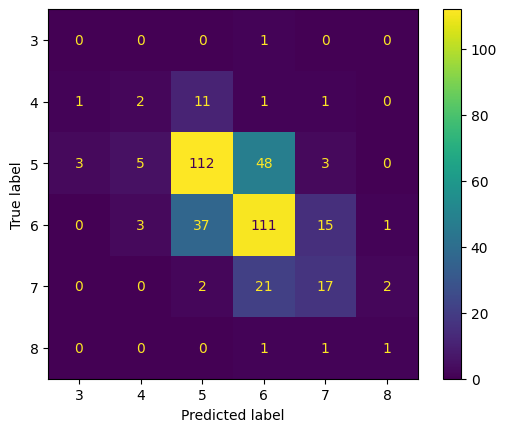

In [49]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [3,4,5,6,7,8])
cm_display.plot()
plt.savefig("Csvm_r.png")

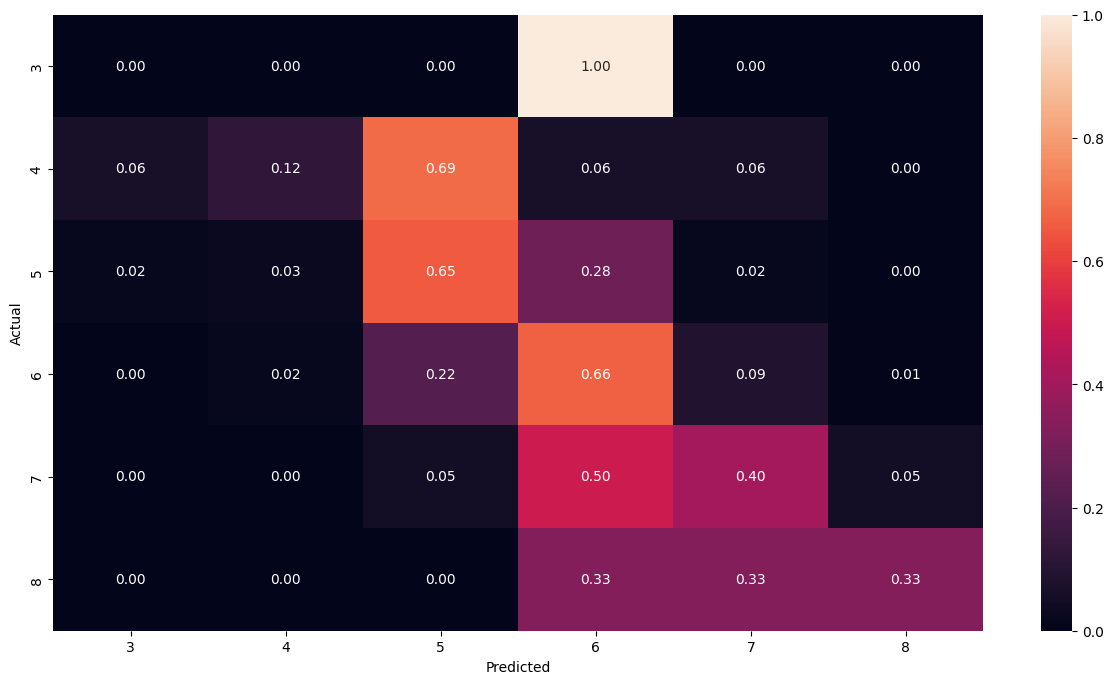

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)